In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import itertools
import math
import hashlib
import matplotlib.cm as cm


In [95]:
# ---------- 1. Catálogos ----------
MARKERS = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', 'h', '8', 'd', 'H',
           '<', '>', 'p', '1', '2', '3', '4']           # 18
COLORS = [cm.get_cmap("tab20")(i) for i in range(20)]  

# ---------- 2. Nueva asignación determinista ----------
def pick_marker_color(model_name: str) -> tuple[str, str]:
    """
    Devuelve (marker, color) únicos para el modelo mientras
    el nº de modelos ≤ len(MARKERS)*len(COLORS).
    """
    h = int(hashlib.sha256(model_name.encode()).hexdigest(), 16)
    combo = h % (len(MARKERS) * len(COLORS))   # 0 … 179

    marker = MARKERS[ combo % len(MARKERS) ]           # posición dentro de MARKERS
    color  = COLORS [ combo // len(MARKERS) ]          # grupo de 18 en 18 → color
    return marker, color


/tmp/ipykernel_48201/2574364198.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLORS = [cm.get_cmap("tab20")(i) for i in range(20)]


In [96]:
def plot_model_performance(
    df,
    model_col='model',
    score_col='bertscore_f1',
    size_col=None,
    parse_size=True,
    figsize=(8, 6),
    title='',
    threshold_lines=None,
    annotate_top_n=0,
):
    """
    Dibuja un diagrama de dispersión rendimiento-vs-tamaño con
    marcador y color fijos por modelo (hash determinista).
    """
    data = df.copy()

    # A) Tamaño del modelo (B) ------------------------------------------------
    if size_col is None:
        if not parse_size:
            raise ValueError("Debes proporcionar size_col o activar parse_size=True")
        def _extract_size_b(text):
            m = re.search(r'(\d+(?:\.\d+)?)([BbMm])', text)
            if m:
                num  = float(m.group(1))
                unit = m.group(2).lower()
                return num / 1_000 if unit == 'm' else num   # M → B
            return math.nan
        data['_size_B'] = data[model_col].apply(_extract_size_b)
        size_col = '_size_B'

    # B) Gráfico --------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    for _, row in data.iterrows():
        model = row[model_col]
        marker, color = pick_marker_color(model)

        ax.scatter(
            row[size_col],
            row[score_col],
            marker=marker,
            color=color,
            s=80,
            edgecolor='black',
            linewidth=0.5,
            label=model,
        )

    # C) Líneas de referencia -------------------------------------------------
    if threshold_lines:
        for y_val, style_kwargs in threshold_lines:
            kwargs = {"linestyle": "--", "linewidth": 1}
            if style_kwargs:
                kwargs.update(style_kwargs)
            ax.axhline(y=y_val, **kwargs)

    # D) Anotar los top-n ------------------------------------------------------
    if annotate_top_n > 0:
        top_rows = data.nlargest(annotate_top_n, score_col)
        for _, row in top_rows.iterrows():
            ax.annotate(
                row[model_col],
                xy=(row[size_col], row[score_col]),
                xytext=(4, 3),
                textcoords='offset points',
                fontsize=8,
            )

    # E) Estética -------------------------------------------------------------
    ax.set_xlabel("Model Parameter Size (B)")
    ax.set_ylabel("BertScore" if score_col == 'bertscore_f1' else "Average Score")
    if title:
        ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 0.9),
              loc="upper left")

    plt.tight_layout()
    return fig, ax

import math, re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_model_performance_v2(
    df: pd.DataFrame,
    model_col: str = 'model',
    score_col: str = 'bertscore_f1',
    size_col: str | None = None,
    parse_size: bool = True,
    figsize: tuple[int, int] = (9, 6),
    title: str = '',
    annotate_top_n: int = 3,
    baseline: str | None = None,
    cmap: str = 'viridis',
    log_x: bool = True,
    trend: bool = True,
):
    """
    Gráfica scatter tamaño-vs-score (más legible y con estilo propio).

    • Color = puntuación (gradiente continuo).
    • Tamaño del marcador = nº parámetros.
    • Eje X opcional log-scale.
    • Anota top-N y baseline.
    • Línea LOWESS opcional.
    """
    data = df.copy()

    # 1) Extraer tamaño si hace falta ------------- #
    if size_col is None:
        if not parse_size:
            raise ValueError("Debes proporcionar size_col o activar parse_size=True")
        def _extract_size_b(text):
            m = re.search(r'(\d+(?:\.\d+)?)([BbMm])', text)
            if m:
                num, unit = float(m.group(1)), m.group(2).lower()
                return num / 1_000 if unit == 'm' else num
            return math.nan
        data['_size_B'] = data[model_col].apply(_extract_size_b)
        size_col = '_size_B'

    # 2) Set-up plot ----------------------------- #
    fig, ax = plt.subplots(figsize=figsize)
    norm = plt.Normalize(vmin=data[score_col].min(), vmax=data[score_col].max())
    sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    # 3) Scatter --------------------------------- #
    sizes_px = data[size_col] * 30  # factor de escala; ajusta si lo ves pequeño/grande
    scatter = ax.scatter(
        data[size_col], data[score_col],
        s=sizes_px,
        c=data[score_col],
        cmap=cmap,
        norm=norm,
        alpha=0.85,
        linewidth=0.5,
        edgecolor='black'
    )

    # 4) Anotaciones ----------------------------- #
    if annotate_top_n > 0:
        top_rows = data.nlargest(annotate_top_n, score_col)
        for _, r in top_rows.iterrows():
            ax.annotate(r[model_col], (r[size_col], r[score_col]),
                        xytext=(5, 5), textcoords='offset points', fontsize=9,
                        weight='bold', bbox=dict(boxstyle='round,pad=0.1', fc='white', alpha=0.6))

    if baseline and baseline in set(data[model_col]):
        r = data.loc[data[model_col] == baseline].iloc[0]
        ax.annotate(f'Baseline\n{baseline}', (r[size_col], r[score_col]),
                    xytext=(0, -25), textcoords='offset points',
                    ha='center', fontsize=9, color='red',
                    arrowprops=dict(arrowstyle='-|>', lw=1, color='red'))

    # 5) LOWESS / regresión ----------------------- #
    if trend:
        sorted_df = data.sort_values(size_col)
        y_smooth  = lowess(sorted_df[score_col], sorted_df[size_col], frac=0.6, return_sorted=False)
        ax.plot(sorted_df[size_col], y_smooth, linestyle='--', linewidth=1.2, label='Tendencia')

    # 6) Estética -------------------------------- #
    ax.set_xlabel("Tamaño del modelo (billones de parámetros)")
    ax.set_ylabel("BERTScore F1" if score_col == 'bertscore_f1' else score_col)
    if title:
        ax.set_title(title, weight='bold')

    if log_x:
        ax.set_xscale('log')
        ax.set_xticks([0.1, 0.3, 1, 3, 10, 30])
        ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax.get_xaxis().set_minor_formatter(plt.NullFormatter())

    ax.grid(True, linestyle=':', alpha=0.4)
    # Color-bar como leyenda de rendimiento
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('BERTScore F1', rotation=270, labelpad=15)

    plt.tight_layout()
    return fig, ax


In [98]:
import math, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────
def _pareto_frontier(df, x_col, y_col):
    """
    Devuelve los puntos de la frontera de Pareto (ordenados por x_col).
    Un punto está en la frontera si no existe otro con
    x ≤ y (menor tamaño) y y ≥ score (mayor o igual rendimiento).
    """
    df_sorted = df.sort_values(x_col)
    best_y = -np.inf
    frontier_rows = []
    for _, row in df_sorted.iterrows():
        if row[y_col] > best_y:
            frontier_rows.append(row)
            best_y = row[y_col]
    return pd.DataFrame(frontier_rows)

# ────────────────────────────────────────────────
def plot_model_performance_v3(
    df: pd.DataFrame,
    model_col: str = 'model',
    score_col: str = 'bertscore_f1',
    size_col: str | None = None,
    parse_size: bool = True,
    figsize: tuple[int, int] = (8, 6),
    title: str = '',
    threshold_lines: list[tuple[float, dict]] | None = None,
    annotate_top_n: int = 0,
    # NUEVOS
    show_frontier: bool = True,
    baseline: float | None = None,
    annotate_eff_n: int = 0,
):
    """
    Scatter tamaño-vs-score fiel al original con añadidos opcionales:

    • show_frontier: dibuja la frontera de Pareto (trade-off óptimo).
    • baseline: traza línea horizontal + banda sutil sobre el baseline.
    • annotate_eff_n: anota los modelos más eficientes (score / size_B).

    Mantiene marcadores/colores deterministas vía pick_marker_color.
    """
    data = df.copy()

    # A) ─── tamaño del modelo (en B) ────────────────────────────────────────
    if size_col is None:
        if not parse_size:
            raise ValueError("Debes proporcionar size_col o activar parse_size=True")

        def _extract_size_b(text):
            m = re.search(r'(\d+(?:\.\d+)?)([BbMm])', str(text))
            if m:
                num, unit = float(m.group(1)), m.group(2).lower()
                return num / 1_000 if unit == 'm' else num
            return math.nan

        data['_size_B'] = data[model_col].apply(_extract_size_b)
        size_col = '_size_B'

    # B) ─── gráfico principal ───────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=figsize)

    for _, row in data.iterrows():
        model = row[model_col]
        marker, color = pick_marker_color(model)

        ax.scatter(
            row[size_col],
            row[score_col],
            marker=marker,
            color=color,
            s=80,
            edgecolor='black',
            linewidth=0.5,
            label=model,
            zorder=3,
        )

    # C) ─── líneas de referencia fijas ──────────────────────────────────────
    if threshold_lines:
        for y_val, style_kwargs in threshold_lines:
            kwargs = {"linestyle": "--", "linewidth": 1}
            if style_kwargs:
                kwargs.update(style_kwargs)
            ax.axhline(y=y_val, **kwargs)

    # D) ─── anotar top-n por score ──────────────────────────────────────────
    if annotate_top_n > 0:
        for _, row in data.nlargest(annotate_top_n, score_col).iterrows():
            ax.annotate(
                row[model_col],
                xy=(row[size_col], row[score_col]),
                xytext=(4, 3),
                textcoords='offset points',
                fontsize=8,
            )

    # E) ─── nueva capa: frontera de Pareto ──────────────────────────────────
    if show_frontier and len(data) >= 2:
        frontier = _pareto_frontier(data, size_col, score_col)
        ax.plot(
            frontier[size_col],
            frontier[score_col],
            linestyle='-',
            color='dimgray',
            linewidth=1.2,
            label='Frontera de Pareto',
            zorder=2,
        )

    # F) ─── nueva capa: banda sobre baseline ────────────────────────────────
    if baseline is not None:
        ax.axhline(baseline, color='red', linestyle='--', linewidth=0.8,
                   label=f'Baseline ({baseline:.2f})', zorder=1.5)
        x_left, x_right = ax.get_xlim()
        ax.fill_between(
            x=[x_left, x_right],
            y1=baseline,
            y2=ax.get_ylim()[1],
            color='red',
            alpha=0.04,
            zorder=1,
        )

    # G) ─── nueva capa: anotaciones de eficiencia ───────────────────────────
    if annotate_eff_n > 0:
        data['eff'] = data[score_col] / data[size_col]
        for _, row in data.nlargest(annotate_eff_n, 'eff').iterrows():
            ax.annotate(
                f"{row['eff']:.2f} pts/B",
                xy=(row[size_col], row[score_col]),
                xytext=(5, -12),
                textcoords='offset points',
                fontsize=7,
                color='steelblue',
            )

    # H) ─── estética final ──────────────────────────────────────────────────
    ax.set_xlabel("Model Parameter Size (B)")
    ax.set_ylabel("BERTScore F1" if score_col == 'bertscore_f1' else "Average Score")
    if title:
        ax.set_title(title)

    ax.grid(True, linestyle="--", alpha=0.5)

    # Leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(
        by_label.values(),
        by_label.keys(),
        bbox_to_anchor=(1.05, 0.9),
        loc="upper left",
    )

    plt.tight_layout()
    return fig, ax


In [129]:
import math, re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ───────── auxiliares ────────────────────────────────────────────────────
def _extract_size_b(text):
    m = re.search(r'(\d+(?:\.\d+)?)([BbMm])', str(text))
    if m:
        num, unit = float(m.group(1)), m.group(2).lower()
        return num / 1_000 if unit == 'm' else num
    return math.nan

# ───────── función ───────────────────────────────────────────────────────
def plot_model_performance_v1_baseline(
    df,
    model_col='model',
    score_col='bertscore_f1',
    baseline_model=None,
    baseline_score=None,
    size_col=None,
    parse_size=True,
    figsize=(8, 6),
    title='',
    annotate_top_n=0,
    hi_vis=True,                # ← NUEVO: activa alta visibilidad
    show_ylabel=True,   # ← NUEVO
    show_legend=True,   # ← NUEVO
):
    # 0) ajustes globales para alta visibilidad -----------------------------
    if hi_vis:
        plt.rcParams.update({
            'font.size': 10,
            'axes.labelsize': 12,
            'axes.titlesize': 13,
            'legend.fontsize': 10,
            'xtick.labelsize': 10,
            'ytick.labelsize': 10,
            'lines.linewidth': 1.6,     # engrosa todos los trazos
            'patch.linewidth': 1,
        })

    # 1) tamaño del modelo ---------------------------------------------------
    data = df.copy()
    if size_col is None:
        if not parse_size:
            raise ValueError("Proporciona size_col o usa parse_size=True")
        data['_size_B'] = data[model_col].apply(_extract_size_b)
        size_col = '_size_B'

    # 2) score del baseline --------------------------------------------------
    if baseline_score is None:
        if baseline_model is None:
            raise ValueError("Necesitas baseline_model o baseline_score")
        try:
            baseline_score = data.loc[data[model_col] == baseline_model, score_col].iloc[0]
        except IndexError:
            raise ValueError("baseline_model no encontrado en el DataFrame")

    # 3) scatter -------------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize, dpi=300 if hi_vis else 100)

    for _, row in data.iterrows():
        marker, color = pick_marker_color(row[model_col])
        ax.scatter(
            row[size_col], row[score_col],
            marker=marker, color=color,
            s=120 if hi_vis else 90,     # marcadores más grandes
            edgecolor='black', linewidth=0.6,
            label=row[model_col], zorder=3
        )

    # 4) banda + línea baseline ---------------------------------------------
    x_left, x_right = ax.get_xlim()
    ax.fill_betweenx([ax.get_ylim()[0], baseline_score],
                     x1=x_left, x2=x_right,
                     color='lightgray', alpha=0.18, zorder=1)
    ax.axhline(baseline_score, color='dimgray', linestyle='--',
               linewidth=1.6, zorder=2)

    label_text = (f'{baseline_model}'
                  if baseline_model else f'baseline')
    ax.text(x_left, baseline_score, f' {label_text} ',
            va='bottom', ha='left',
            fontsize=6 if hi_vis else 30,   # más pequeño aún
            color='red', backgroundcolor='white')

    # 5) anotaciones top-n a la izquierda ------------------------------------
    if annotate_top_n > 0:
        for _, row in data.nlargest(annotate_top_n, score_col).iterrows():
            ax.annotate(
                row[model_col],
                xy=(row[size_col], row[score_col]),
                xytext=(-6, 3), textcoords='offset points',
                ha='right', va='bottom',
                fontsize=8 if hi_vis else 20,
                weight='semibold'
            )

        # 6) estética y leyenda --------------------------------------------------
    ax.set_xlabel("Model Parameter Size (B)")
    if show_ylabel:
        y_label = "BERTScore" if score_col == 'bertscore_f1' else score_col
        ax.set_ylabel(y_label)
    if title:
        ax.set_title(title, weight='bold')
    ax.grid(True, linestyle='--', alpha=0.4)

    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        """ax.legend(
            uniq.values(), uniq.keys(),
            bbox_to_anchor=(1.03, 1), loc='upper left',
            frameon=False, fontsize=9,
            labelspacing=1.3
        )"""
        ax.legend(
            uniq.values(), uniq.keys(),
            loc='lower center',           # Coloca la leyenda abajo dentro del espacio del bbox
            bbox_to_anchor=(0.5, 1.02),   # Centrado horizontalmente, justo por encima del eje
            ncol=len(uniq)/3,               # Número de columnas igual al número de entradas
            frameon=False,
            fontsize=9,
            labelspacing=1.3
        )


    plt.tight_layout()
    return fig, ax




/tmp/ipykernel_48201/2464481416.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('4').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_48201/2464481416.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_48201/2464481416.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


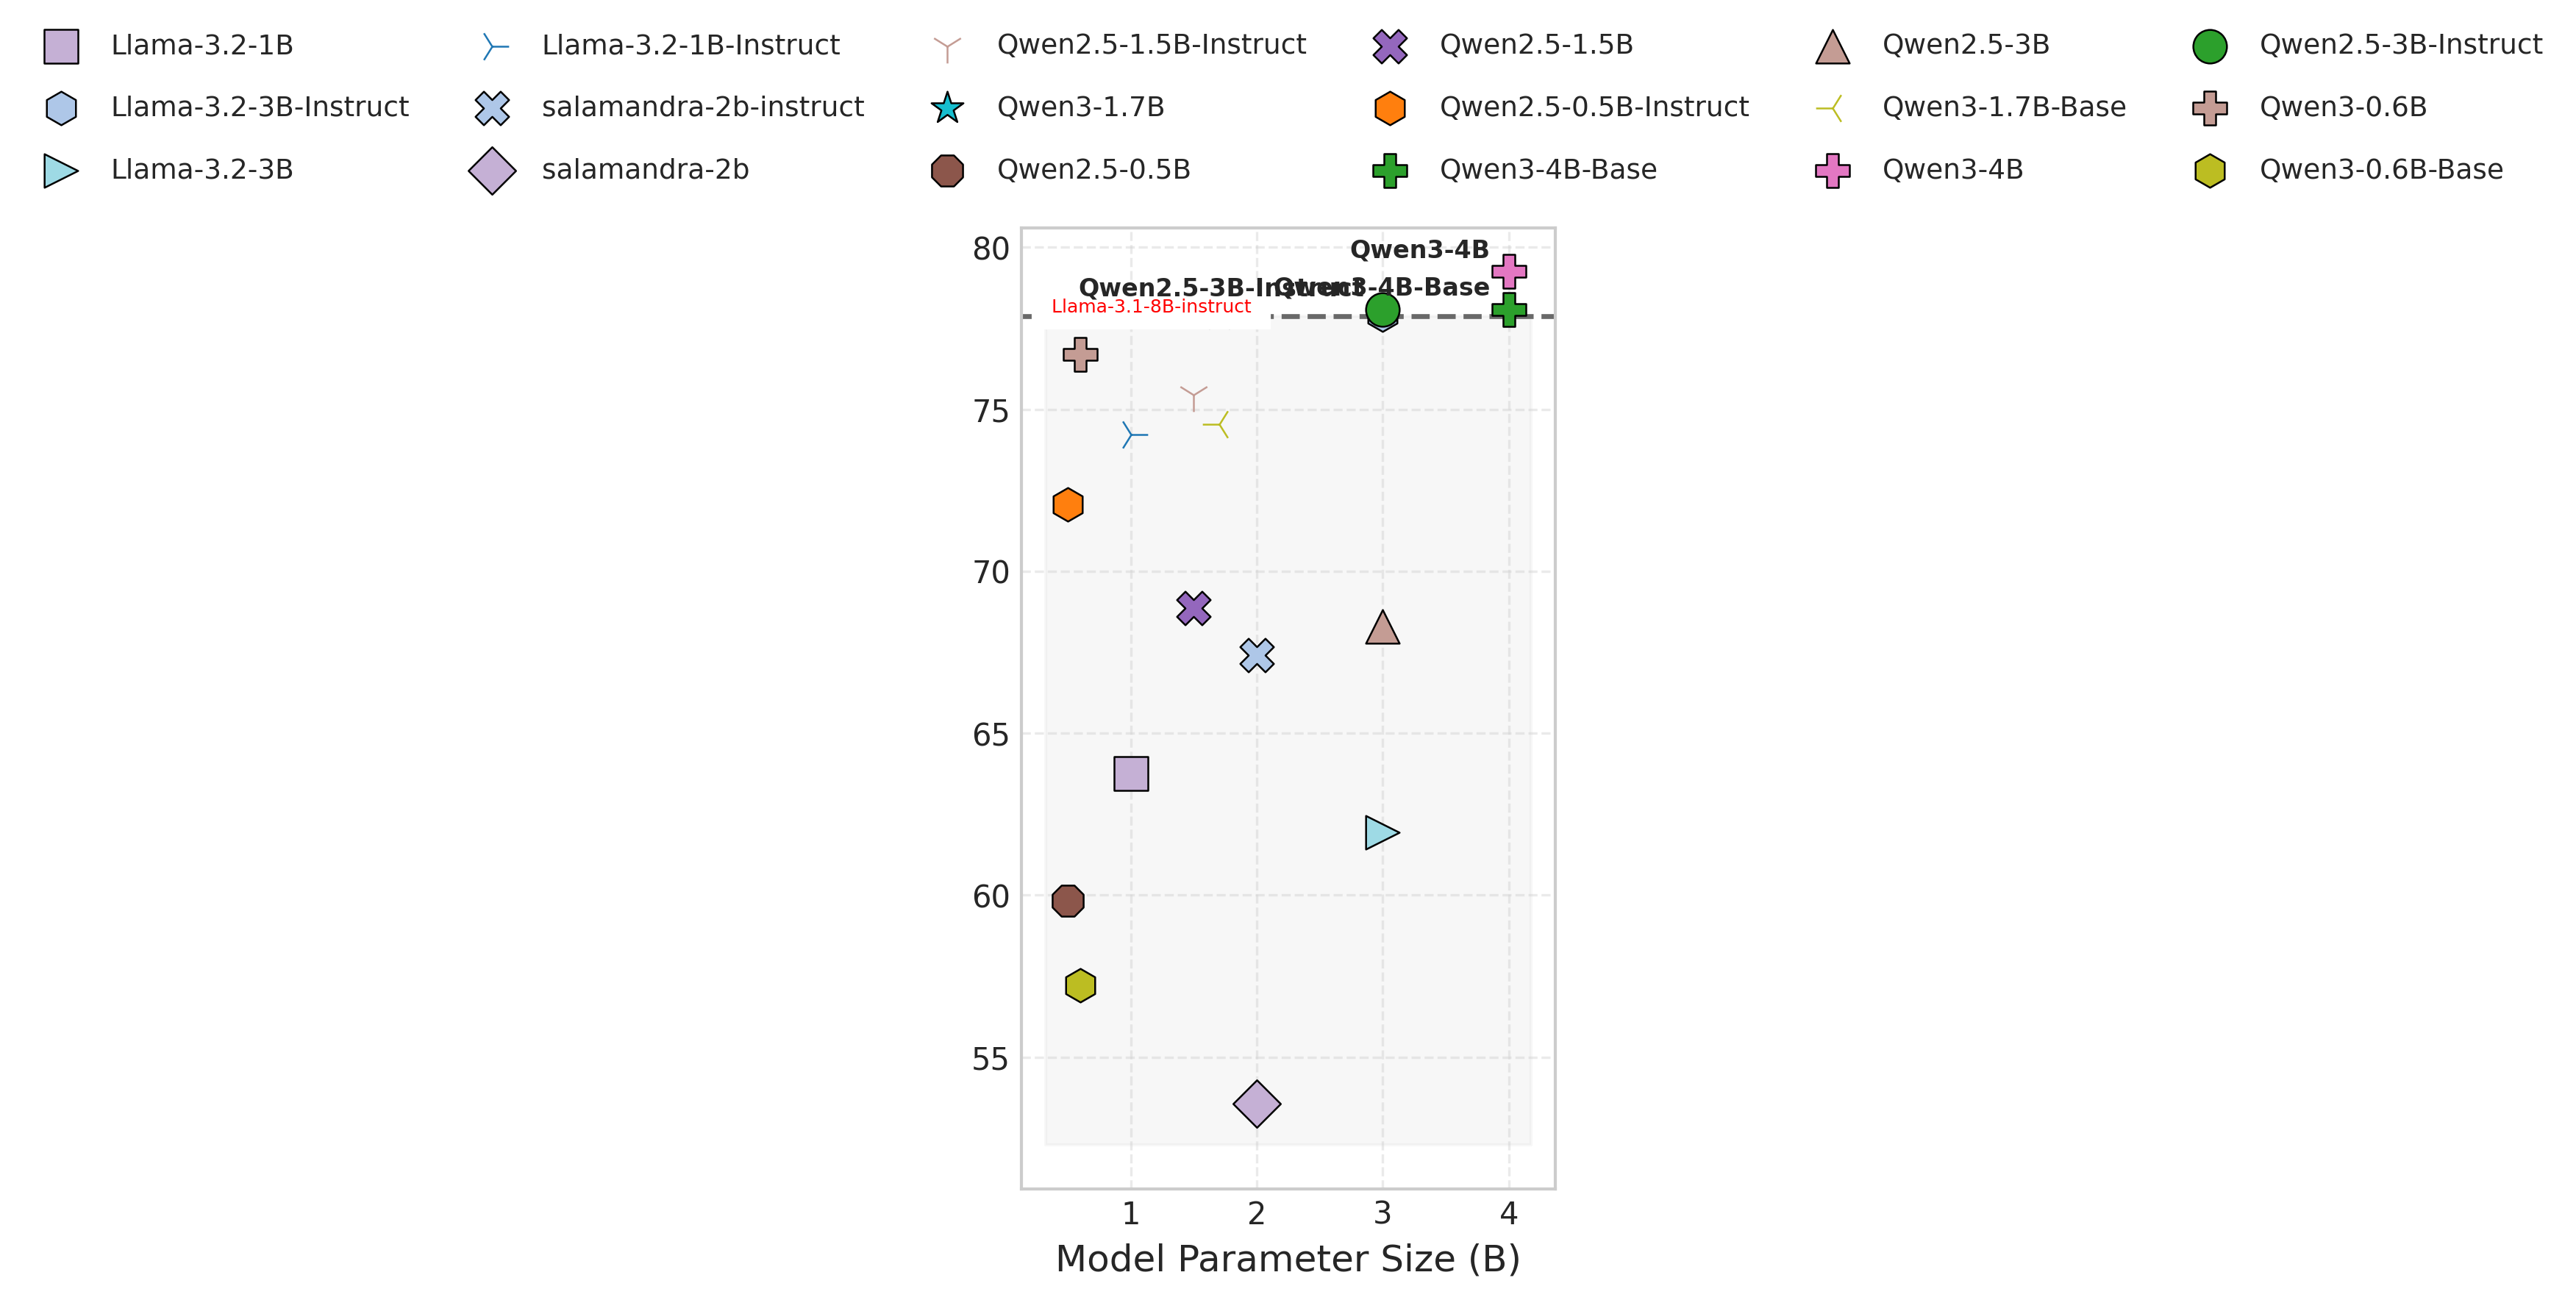

In [131]:
sheet = "canario"
df = pd.read_excel("data/metrics_summary_not_ft.xlsx", sheet_name=sheet)
score_col = "bertscore_f1"

baseline = {
    "bertscore_f1": [(77.88, {"color": "red", "label": "Qwen3-30B"})],
    "average":      [(4.58,  {"color": "red", "label": "Qwen3-30B"})],
}

fig, ax = plot_model_performance_v1_baseline(
    df,
    score_col=score_col,               # o 'bertscore_f1'
    title=None,
    baseline_model="Llama-3.1-8B-instruct",
    baseline_score=baseline[score_col][0][0],
    #threshold_lines=baseline[score_col],
    annotate_top_n=3,
    hi_vis=True,  # Activa alta visibilidad
    show_ylabel=False,   # ← NUEVO
    show_legend=True,   # ← NUEVO
)
plt.show()

/tmp/ipykernel_48201/451730838.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_48201/451730838.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(
/tmp/ipykernel_48201/451730838.py:65: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('4').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


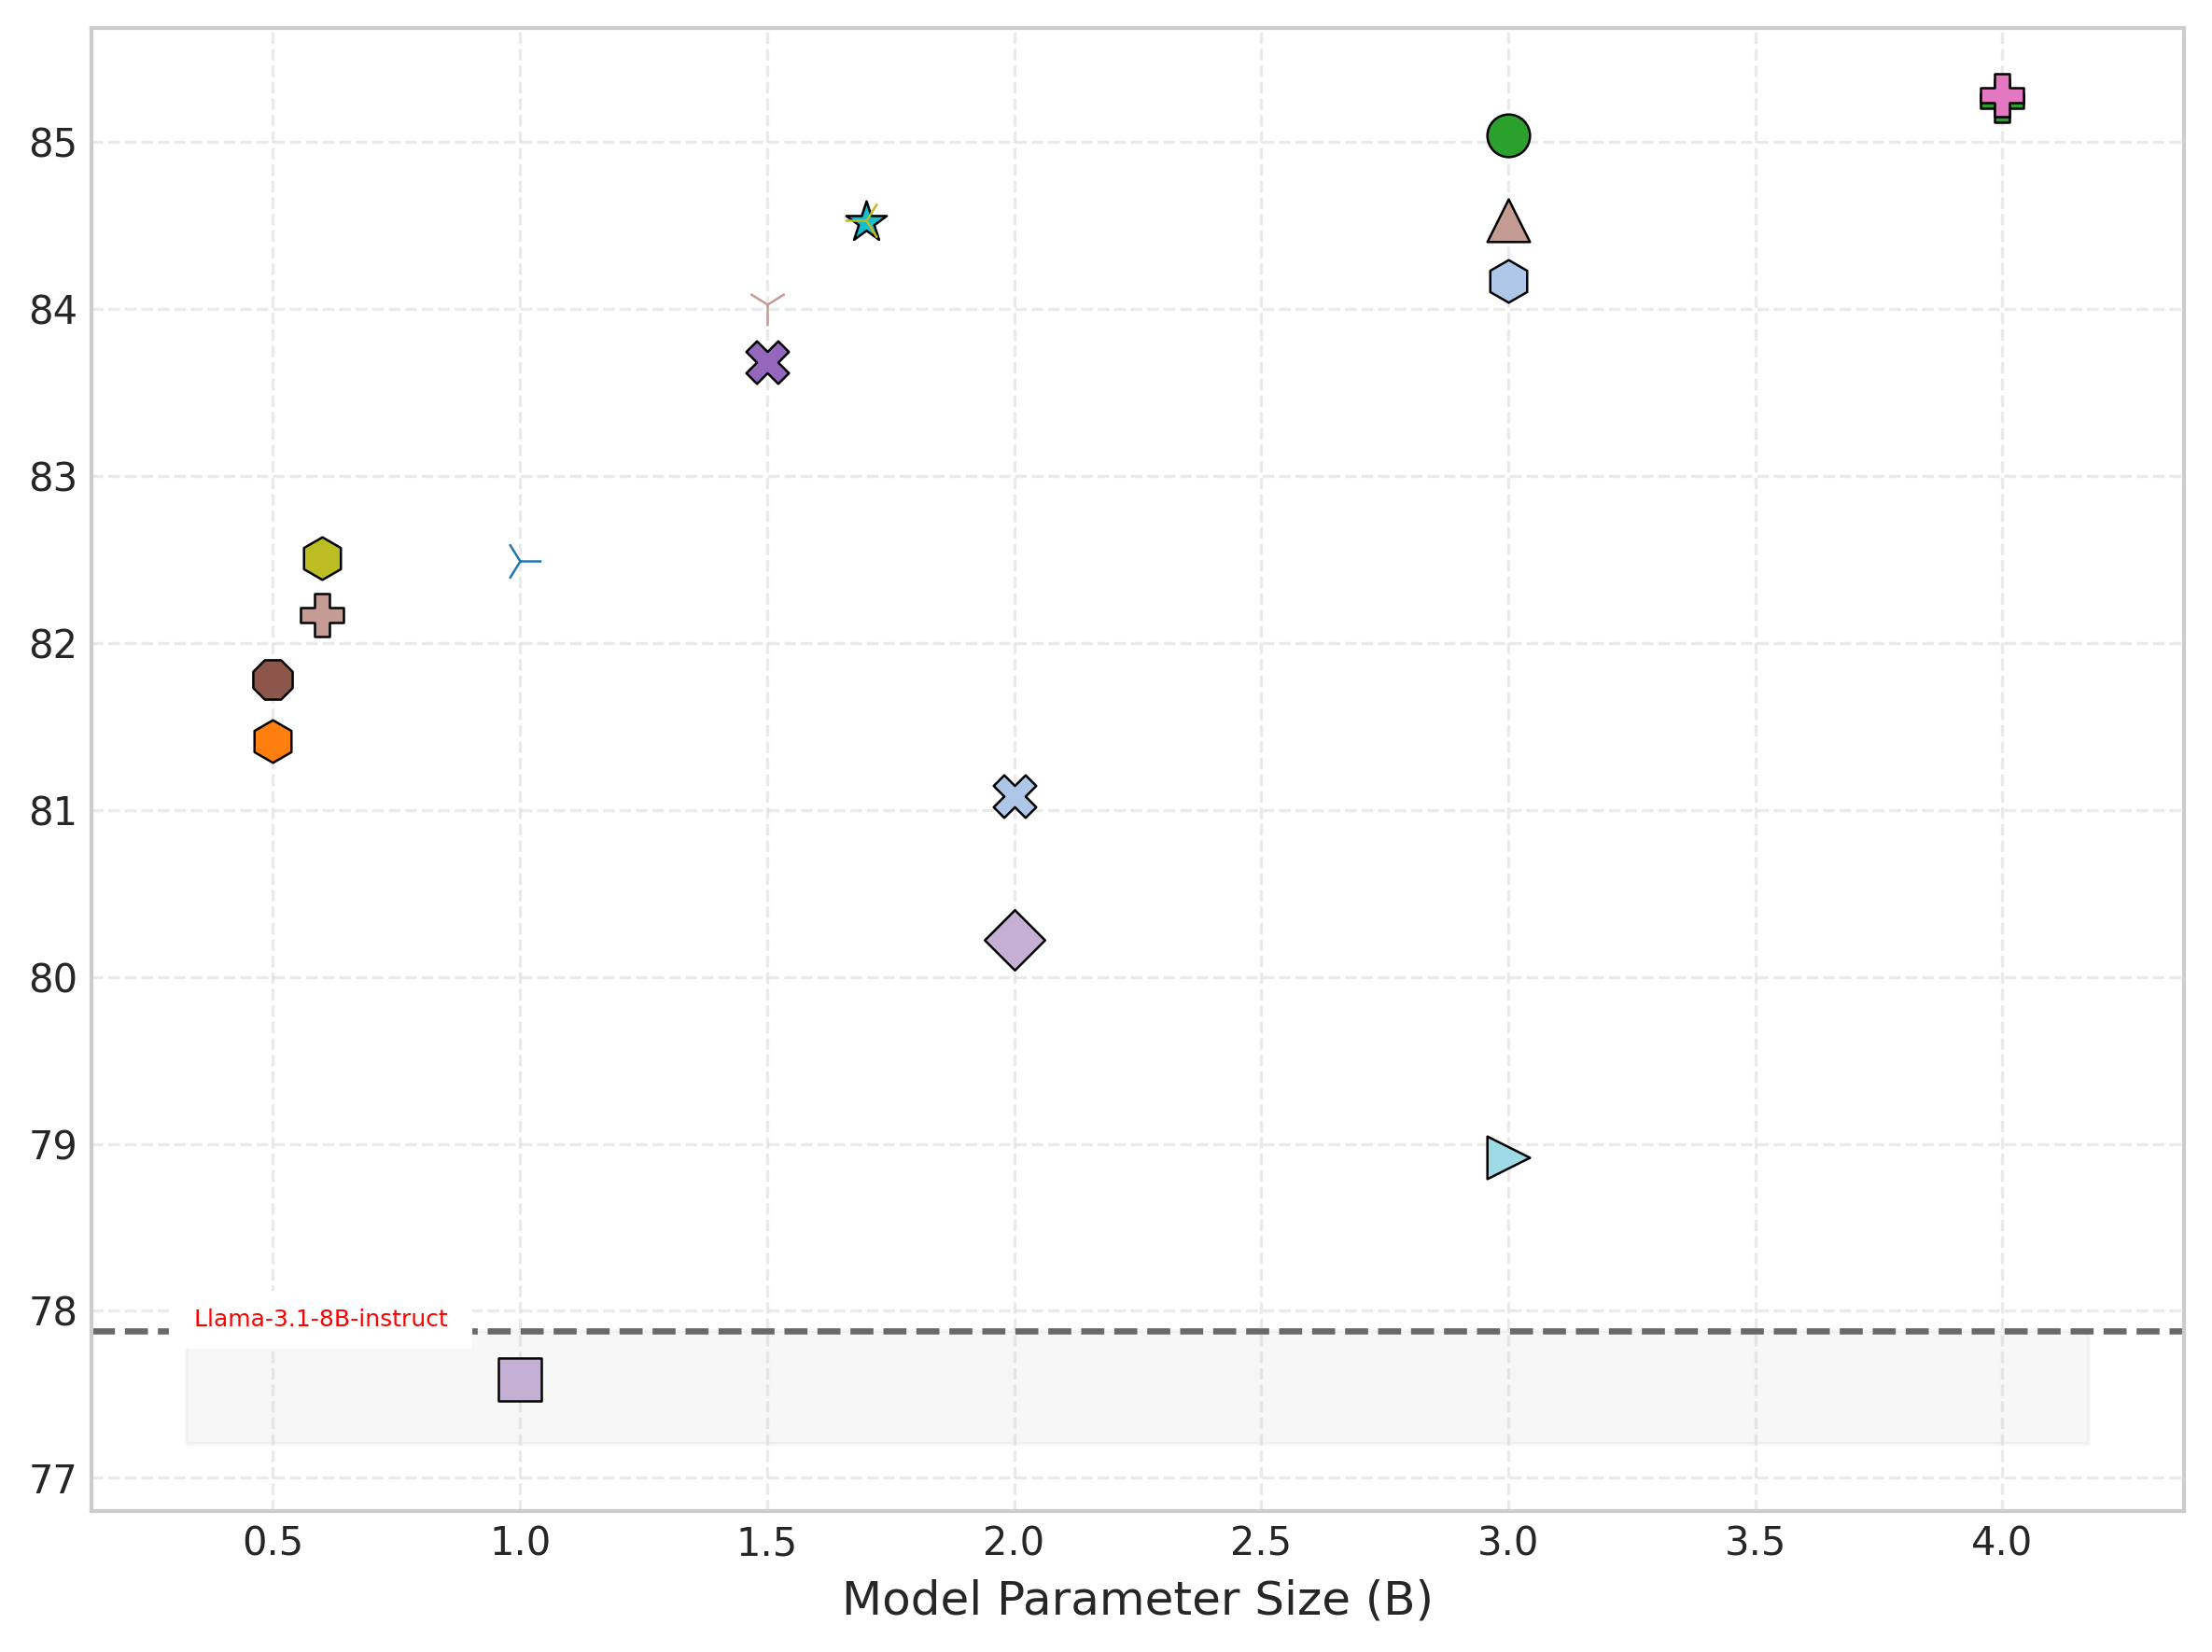

In [122]:
df = pd.read_excel("data/metrics_summary_ft.xlsx", sheet_name=sheet)
# replace name of model (ft) by ""
df['model'] = df['model'].str.replace('(ft)', '', regex=False)
# strip whitespace from model names
df['model'] = df['model'].str.strip()
fig, ax = plot_model_performance_v1_baseline(
    df,
    score_col=score_col,               # o 'bertscore_f1'
    title=None,
    baseline_model="Llama-3.1-8B-instruct",
    baseline_score=baseline[score_col][0][0],
    #threshold_lines=baseline[score_col],
    annotate_top_n=0,
    hi_vis=True,  # Activa alta visibilidad
    show_ylabel=False,   # ← NUEVO
    show_legend=False,   # ← NUEVO
)
plt.show()

TypeError: plot_panel() got an unexpected keyword argument 'show_ylabel'

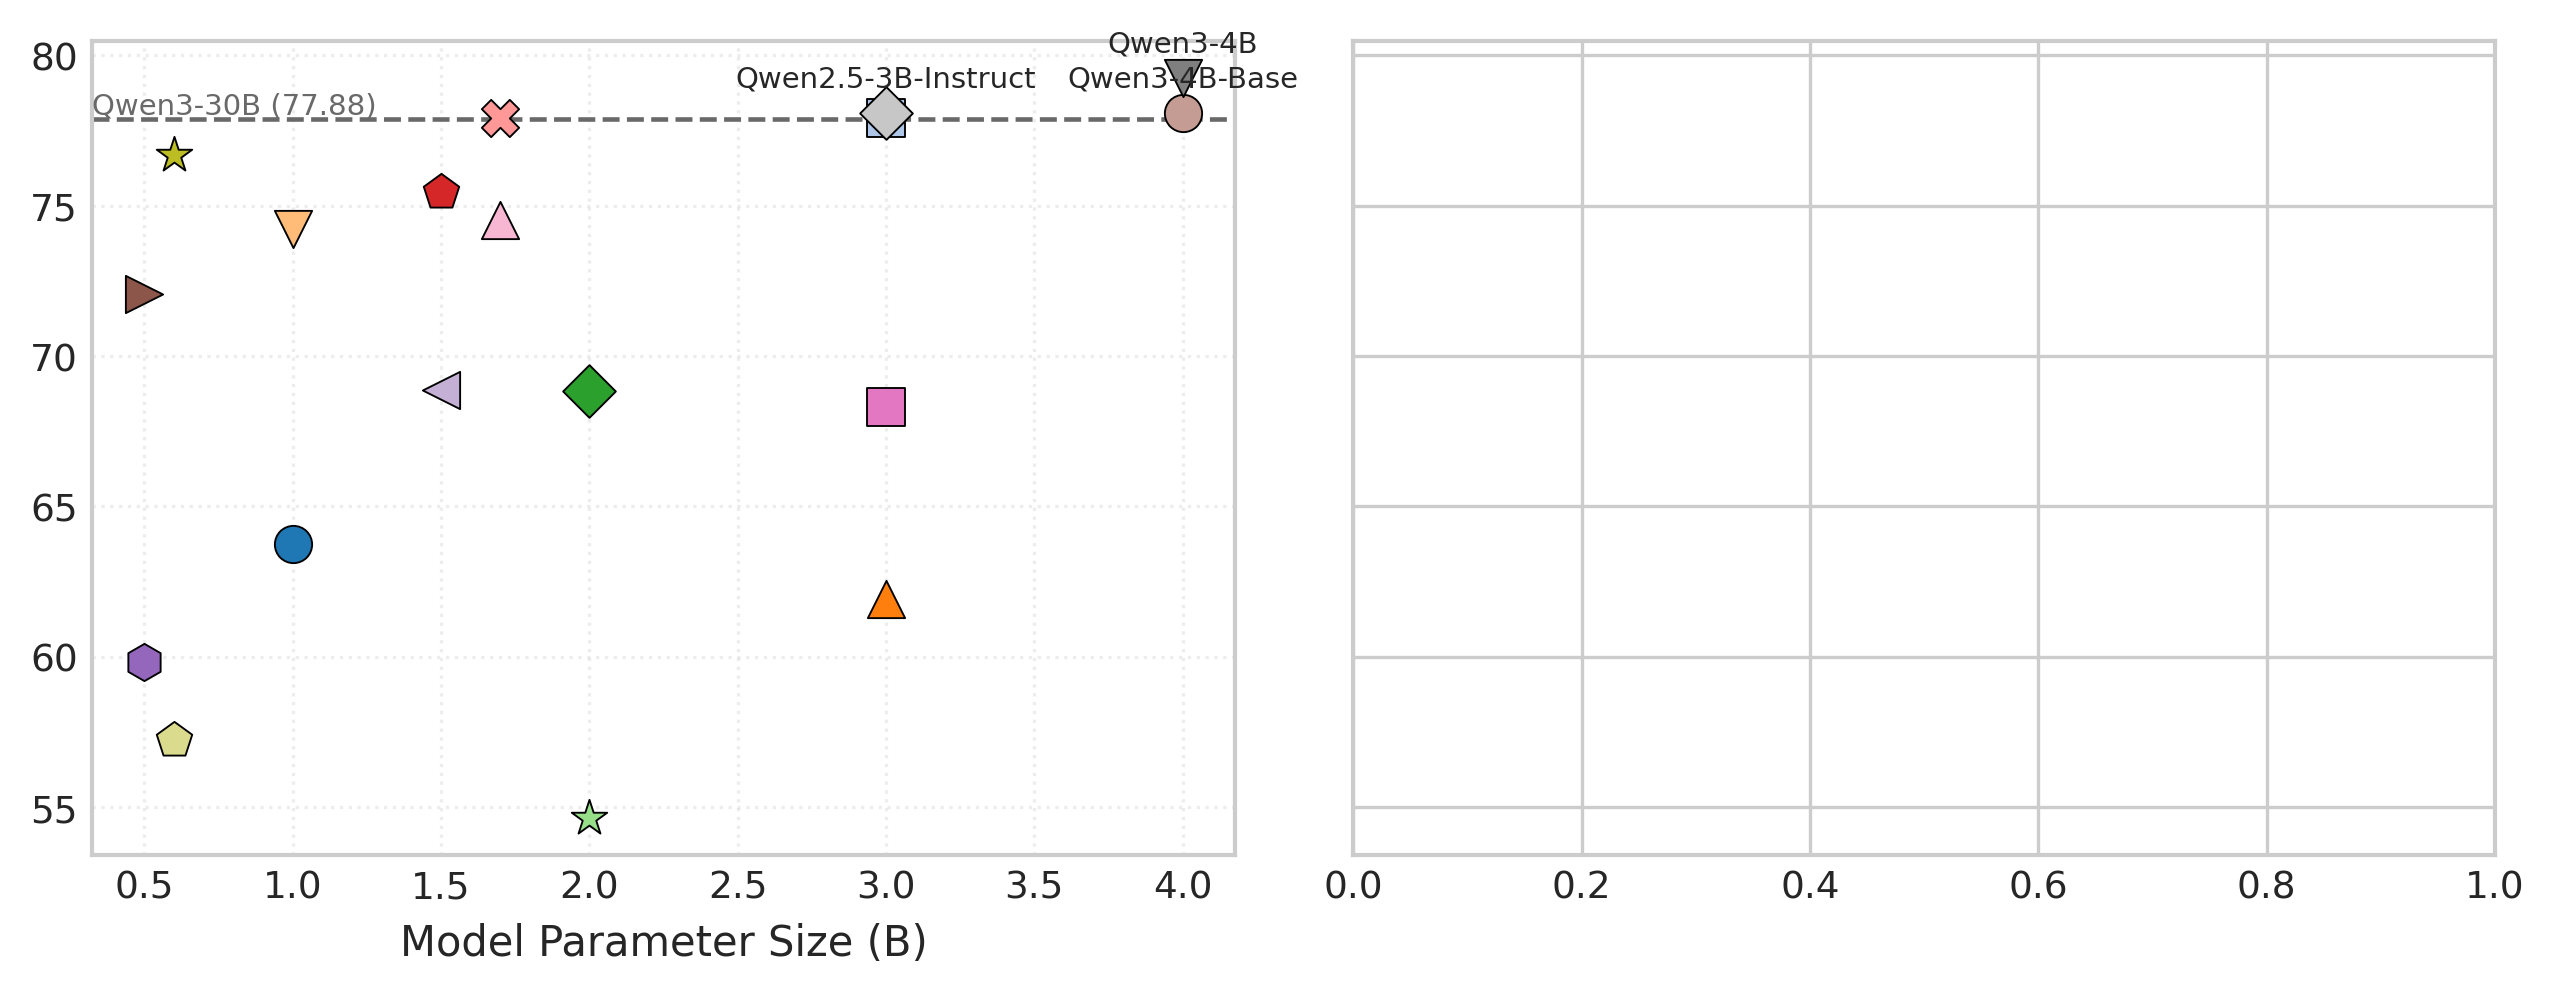

In [93]:
import math, re
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle

# ── util mini para marcar/colorear de forma estable ──
_markers = cycle("os^vD*pXh<>")
_colors  = cycle(plt.cm.tab20.colors)
_cache   = {}
def pick_marker_color(name):
    if name not in _cache:
        _cache[name] = (next(_markers), next(_colors))
    return _cache[name]

def _extract_size_b(text):
    m = re.search(r'(\d+(?:\.\d+)?)([BbMm])', str(text))
    if m:
        num, unit = float(m.group(1)), m.group(2).lower()
        return num / 1_000 if unit == 'm' else num
    return math.nan

# ── panel sencillo (sin banda) ───────────────────────
def plot_panel(
    df, ax,
    *, score_col, baseline_score, baseline_label,
    annotate_top_n=3,
    model_col='model',
    size_col=None, parse_size=True,
):
    # tamaño en B
    if size_col is None:
        df = df.assign(size_B=df[model_col].apply(_extract_size_b))
        size_col = 'size_B'

    # scatter
    for _, r in df.iterrows():
        m, c = pick_marker_color(r[model_col])
        ax.scatter(r[size_col], r[score_col], marker=m, color=c,
                   s=80, edgecolor='black', linewidth=0.45,
                   label=r[model_col], zorder=3)

    # baseline (solo línea)
    ax.axhline(baseline_score, ls='--', lw=1.1, color='dimgray', zorder=1.5)
    ax.text(ax.get_xlim()[0], baseline_score,
            f'{baseline_label} ({baseline_score:.2f})',
            va='bottom', ha='left', fontsize=7, color='dimgray')

    # anotaciones top-n
    if annotate_top_n:
        for _, r in df.nlargest(annotate_top_n, score_col).iterrows():
            ax.annotate(r[model_col], (r[size_col], r[score_col]),
                        xytext=(0, 5), textcoords='offset points',
                        ha='center', va='bottom', fontsize=7)

    ax.set_xlabel("Model Parameter Size (B)")
    ax.grid(True, ls=':', alpha=.35)

# ── datos ────────────────────────────────────────────
sheet = "canario"
score_col = "bertscore_f1"
baseline_score = 77.88
baseline_label = "Qwen3-30B"

df_before = pd.read_excel("data/metrics_summary_not_ft.xlsx", sheet_name=sheet)
df_after  = (pd.read_excel("data/metrics_summary_ft.xlsx", sheet_name=sheet)
             .assign(model=lambda d: d['model'].str.replace('(ft)', '', regex=False).str.strip()))

# ── figura doble ─────────────────────────────────────
plt.rcParams.update({
    'font.size': 9, 'axes.labelsize': 10, 'axes.titlesize': 11,
    'legend.fontsize': 9, 'lines.linewidth': 1.4
})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.4, 3.2),
                               sharey=True, dpi=300,
                               constrained_layout=True)

plot_panel(df_before, ax1,
           score_col=score_col,
           baseline_score=baseline_score, baseline_label=baseline_label,
           annotate_top_n=3)

plot_panel(df_after,  ax2,
           score_col=score_col,
           baseline_score=baseline_score, baseline_label=baseline_label,
           annotate_top_n=3, show_ylabel=False)

ax1.set_ylabel("BERTScore")
ax1.set_title("(a) Before fine-tuning", weight='bold')
ax2.set_title("(b) After fine-tuning",  weight='bold')

# leyenda global
h, l = ax1.get_legend_handles_labels()
uniq = dict(zip(l, h))
fig.legend(uniq.values(), uniq.keys(),
           ncol=4, loc='lower center',
           bbox_to_anchor=(0.5, -0.08),
           frameon=False, columnspacing=1.0)

fig.savefig("bertscore_panels_clean.pdf", bbox_inches='tight')
plt.show()




/tmp/ipykernel_48201/2335012509.py:51: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('4').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(r[size_col], r[score_col],
/tmp/ipykernel_48201/2335012509.py:51: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(r[size_col], r[score_col],
/tmp/ipykernel_48201/2335012509.py:51: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(r[size_col], r[score_col],
/tmp/ipykernel_48201/2335012509.py:51: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the face

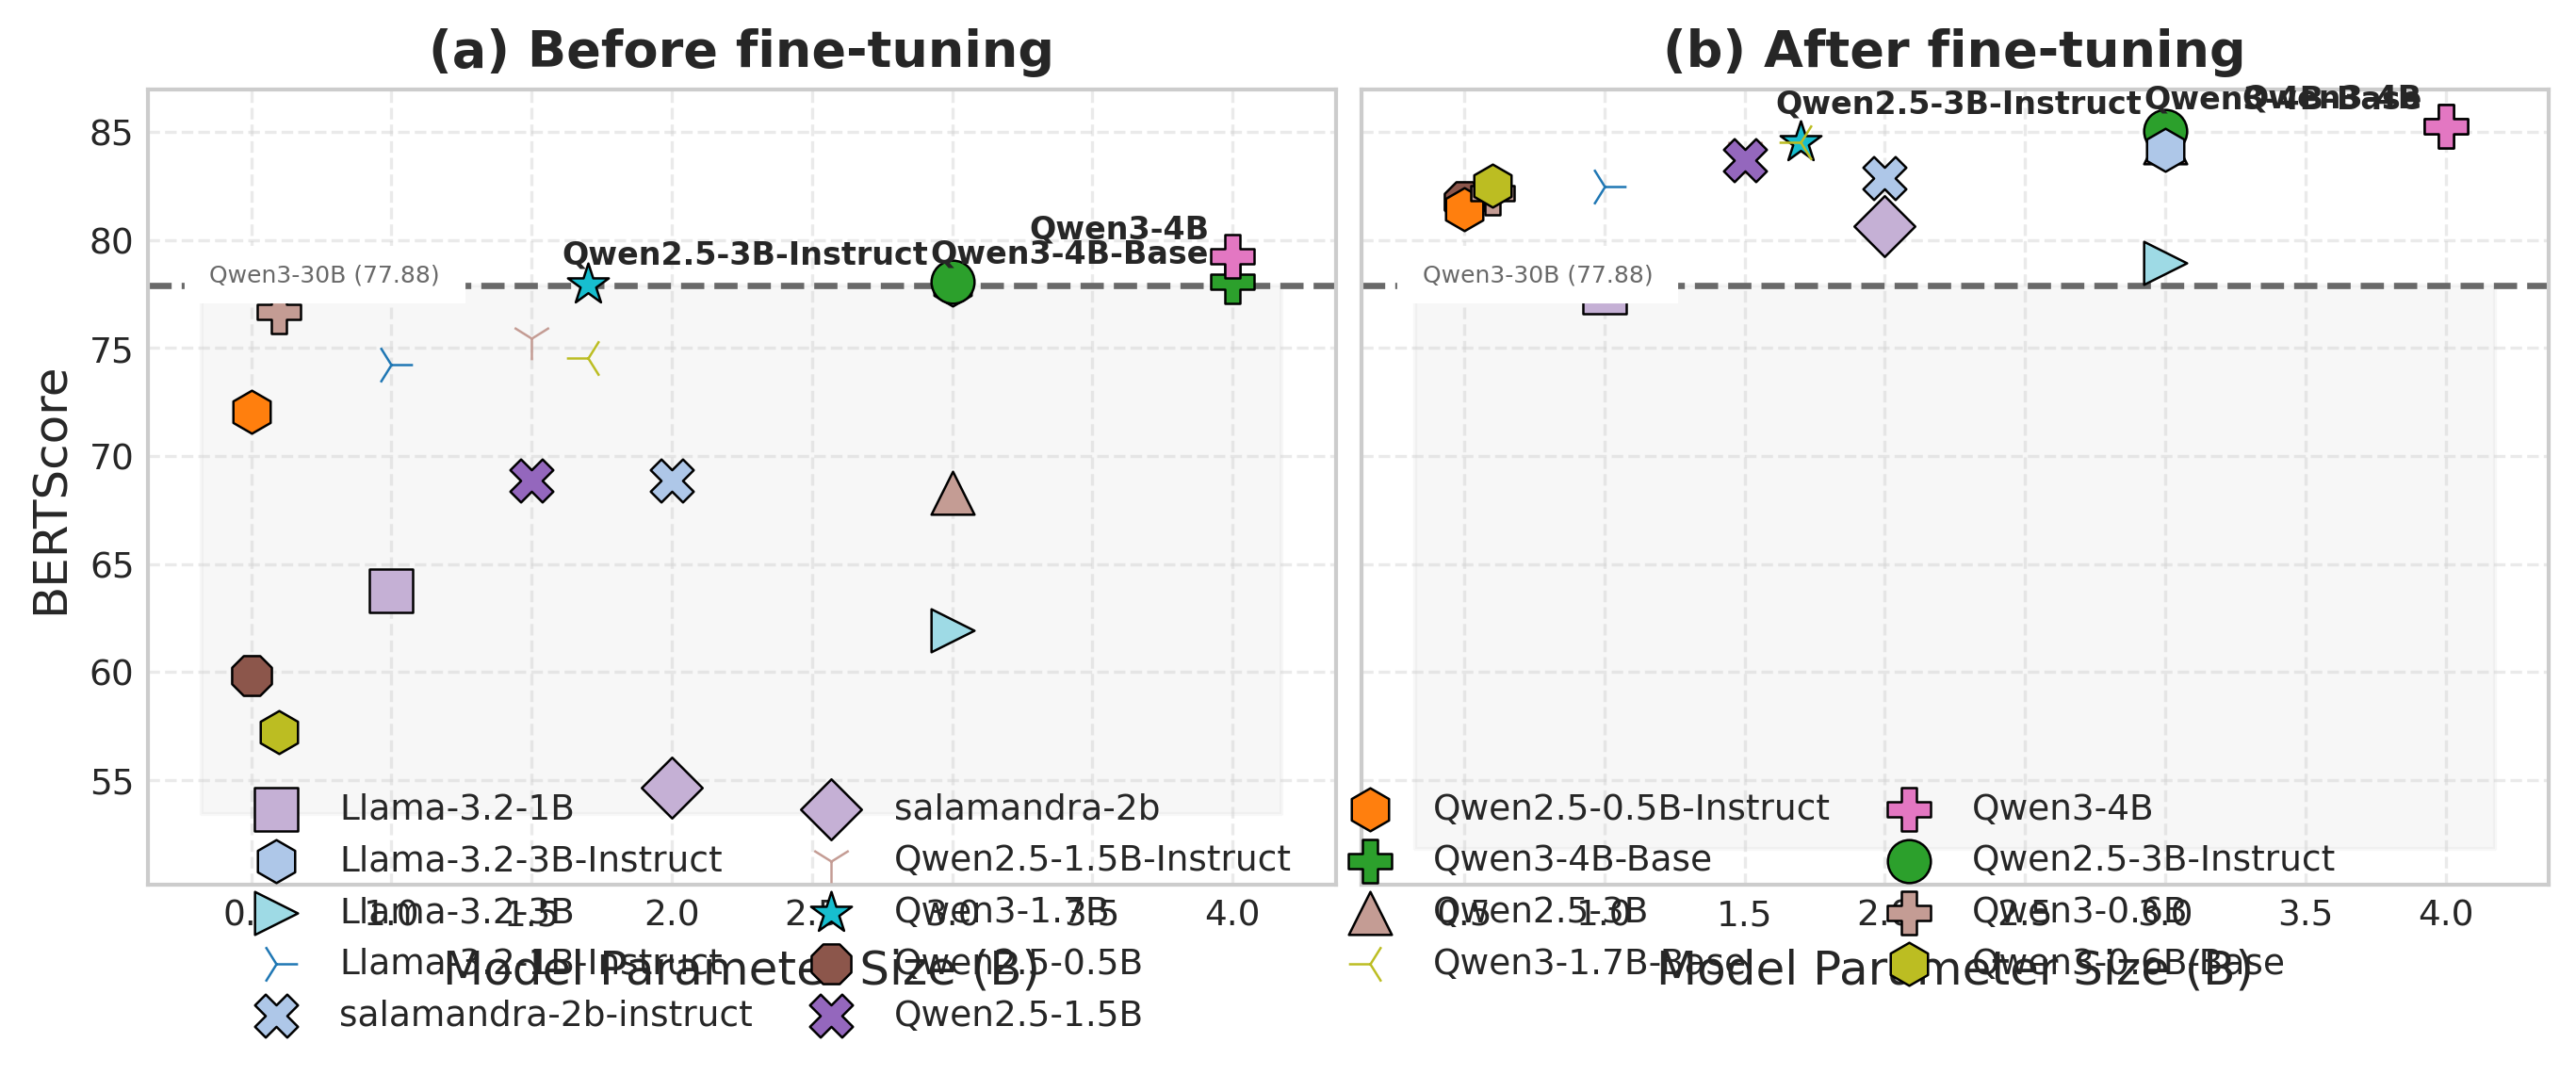

In [92]:
sheet = "canario"
score_col = "bertscore_f1"
baseline_score = 77.88
baseline_label = "Qwen3-30B"

# ── DataFrames ─────────────────────────────────────
df_before = pd.read_excel("data/metrics_summary_not_ft.xlsx", sheet_name=sheet)
df_after  = (pd.read_excel("data/metrics_summary_ft.xlsx", sheet_name=sheet)
             .assign(model=lambda d: d['model'].str.replace('(ft)', '', regex=False).str.strip()))

# ── Figura con 2 subplots ──────────────────────────
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(9, 3.5), sharey=True, dpi=300, constrained_layout=True
)

plot_model_performance_v1_baseline(
    df_before, ax=ax1,
    score_col=score_col,
    baseline_score=baseline_score,
    baseline_label=baseline_label,
    annotate_top_n=3,
    hi_vis=True,
    show_ylabel=True,
    show_legend=False          # leyenda global luego
)
ax1.set_title("(a) Before fine-tuning", weight='semibold')

plot_model_performance_v1_baseline(
    df_after, ax=ax2,
    score_col=score_col,
    baseline_score=baseline_score,
    baseline_label=baseline_label,
    annotate_top_n=3,
    hi_vis=True,
    show_ylabel=False,
    show_legend=False
)
ax2.set_title("(b) After fine-tuning",  weight='semibold')

# ── leyenda global debajo ─────────────────────────
handles, labels = ax1.get_legend_handles_labels()
uniq = dict(zip(labels, handles))
fig.legend(uniq.values(), uniq.keys(),
           ncol=4, loc='lower center',
           bbox_to_anchor=(0.5, -0.06),
           frameon=False, fontsize=9, columnspacing=1.2)

fig.savefig("bertscore_panels.pdf", bbox_inches='tight')
plt.show()




## HeatMap

In [176]:
import pandas as pd
import matplotlib.pyplot as plt


_SIZE_RE = re.compile(r"(\d+(?:\.\d+)?)([MB])", re.I)


def _parse_size(model_name: str) -> float:
    """
    Devuelve el tamaño del modelo en **billions** a partir del nombre.
    Ej.: 'Llama-3-8B-Instruct' -> 8.0 ; 'Qwen-0.6B' -> 0.6 ; '7M' -> 0.007
    """
    m = _SIZE_RE.search(model_name)
    if not m:
        return float("inf")            # sin cifra → lo mandamos al final
    value, unit = m.groups()
    value = float(value)
    return value if unit.upper() == "B" else value / 1000.0   # M → billones

def _get_label_name(metric: str) -> str:
    """
    Devuelve el nombre de la métrica para el título del gráfico.
    """
    metrics_names = {
        "average": "Average Score",
        "bertscore_f1": "BERTScore",
        "rougeL": "ROUGE-L",
    }

    return metrics_names[metric] if metric in metrics_names else metric

def show_metrics_heatmap(
    excel_path: str,
    metric: str = "average",
    index_col: str = "model",
    title: str = None,
    cmap: str = "viridis",
    show_top: bool = True,
    sort_by_size: bool = True,
    exclude_models: list[str] | None = None, 
):
    """
    Dibuja un heat-map de la métrica `metric` para cada modelo↔idioma y
    muestra la tabla con el mejor modelo por idioma.

    Parameters
    ----------
    excel_path : str
        Ruta al archivo .xlsx que tiene una hoja por idioma.
    metric : str, default "average"
        Nombre de la columna que contiene la métrica que quieres visualizar.
    index_col : str, default "model"
        Columna que identifica al modelo.
    show_top : bool, default True
        Muestra/retorna la tabla 'mejor modelo por idioma'.

    Returns
    -------
    summary_df : pd.DataFrame
        Tabla pivote (filas=modelos, columnas=idiomas).
    best_models_df : pd.DataFrame
        Tabla con el mejor modelo por idioma.
    """
    # 1. Cargar todas las hojas
    xls = pd.ExcelFile(excel_path)
    sheets = xls.sheet_names

    summary = {}
    best_per_lang = []

    for sheet in sheets:
        if sheet == "canario":
            continue
        df = pd.read_excel(xls, sheet_name=sheet).assign(model=lambda d: d['model'].str.replace('(ft)', '', regex=False).str.strip())
        df = df[~df[index_col].isin(exclude_models)]
        if metric not in df.columns:
            print(f"⚠️ La métrica '{metric}' no existe en la hoja '{sheet}'. Se omite.")
            continue

        summary[sheet] = df.set_index(index_col)[metric]

        best_idx = df[metric].idxmax()
        best_row = df.loc[best_idx]
        best_per_lang.append(
            {"language": sheet, "best_model": best_row[index_col], metric: best_row[metric]}
        )

    if not summary:
        raise ValueError("La métrica indicada no se encontró en ninguna hoja.")

    # 2. Tabla pivote para el heat-map
    summary_df = pd.DataFrame(summary).sort_index()

    # --- 2. Ordenar por tamaño de modelo ---
    if sort_by_size:
        order = sorted(summary_df.index, key=_parse_size)
        summary_df = summary_df.loc[order]

    # 3. Mejores modelos por idioma
    best_models_df = pd.DataFrame(best_per_lang).set_index("language")
    if show_top:
        print("\nMejor modelo por idioma:\n", best_models_df)

    # 4. Heat-map
    plt.figure(figsize=(10, 0.4 * len(summary_df) + 2))
    im = plt.imshow(summary_df, aspect="auto", cmap=cmap)
    ax.grid(False)      
    label_name = _get_label_name(metric)

    if metric == "average":
        ticks = [1, 2, 3, 4, 5]
        cbar = plt.colorbar(im, label=label_name, orientation='vertical', ticks=ticks)
    else:
        cbar = plt.colorbar(im, label=label_name, orientation='vertical')
        
    cbar.ax.invert_yaxis()
    plt.yticks(range(len(summary_df.index)), summary_df.index)
    plt.xticks(
        range(len(summary_df.columns)), summary_df.columns, rotation=45, ha="right"
    )
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

    return summary_df, best_models_df


Heatmap of average scores (not_ft)

Mejor modelo por idioma:
             best_model  average
language                       
french        Qwen3-4B     4.55
english     Qwen3-1.7B     4.66
portuguese  Qwen3-1.7B     4.59
italian     Qwen3-1.7B     4.43
spanish     Qwen3-1.7B     4.57
german        Qwen3-4B     4.45


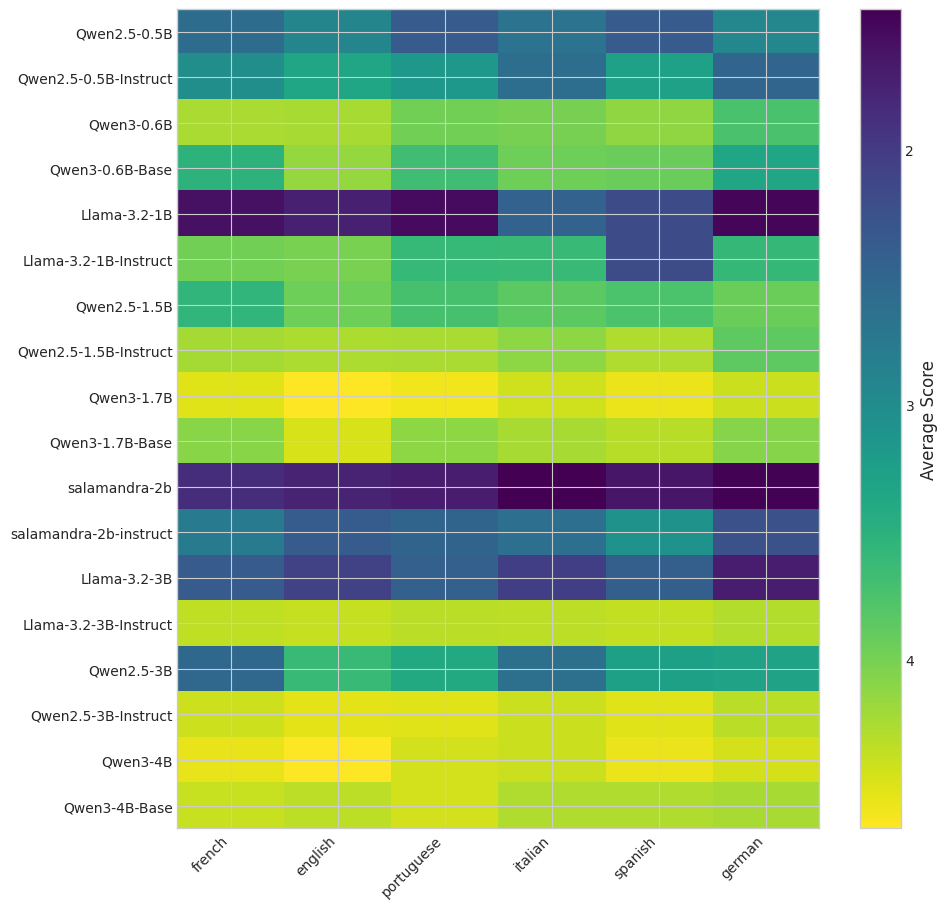

Heatmap of average scores (ft)

Mejor modelo por idioma:
                      best_model  average
language                                
english              Qwen2.5-3B     4.15
french            Qwen3-4B-Base     3.85
italian           Qwen3-4B-Base     3.91
german          Qwen3-1.7B-Base     3.92
spanish     Qwen2.5-3B-Instruct     3.97
portuguese        Qwen3-4B-Base     3.95


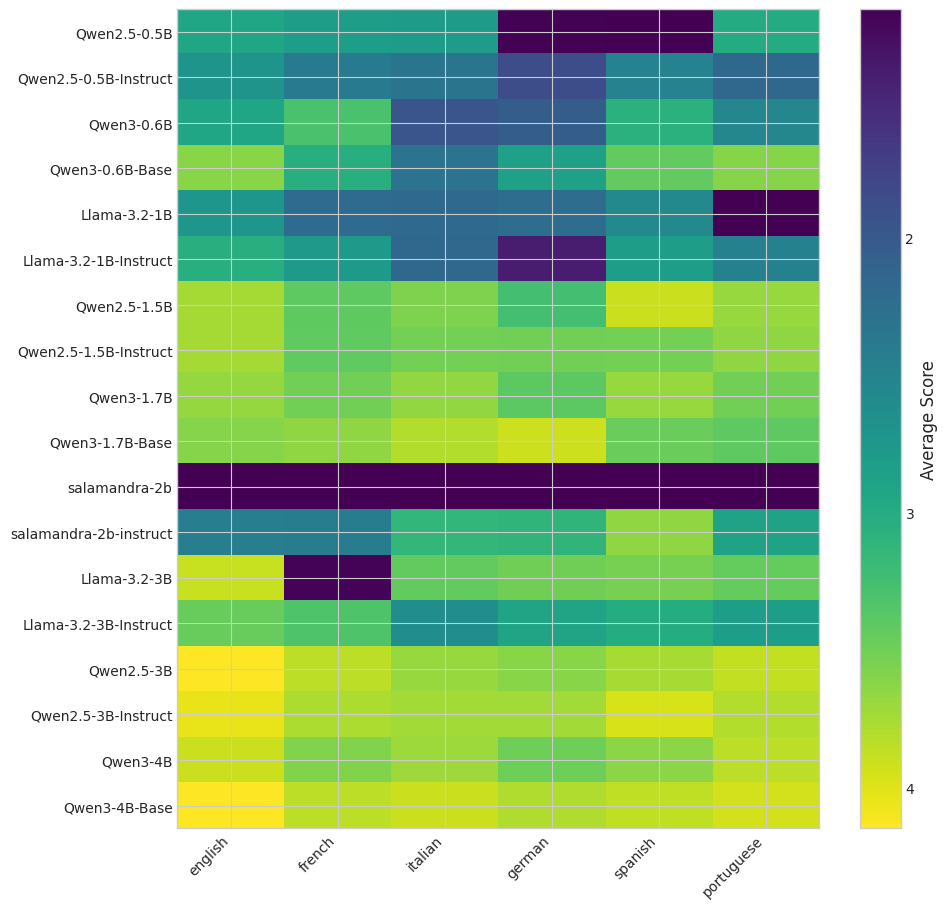

Heatmap of bertscore_f1 scores (not_ft)

Mejor modelo por idioma:
            best_model  bertscore_f1
language                           
french       Qwen3-4B         75.26
english      Qwen3-4B         74.14
portuguese   Qwen3-4B         75.80
italian      Qwen3-4B         75.54
spanish      Qwen3-4B         75.68
german       Qwen3-4B         73.66


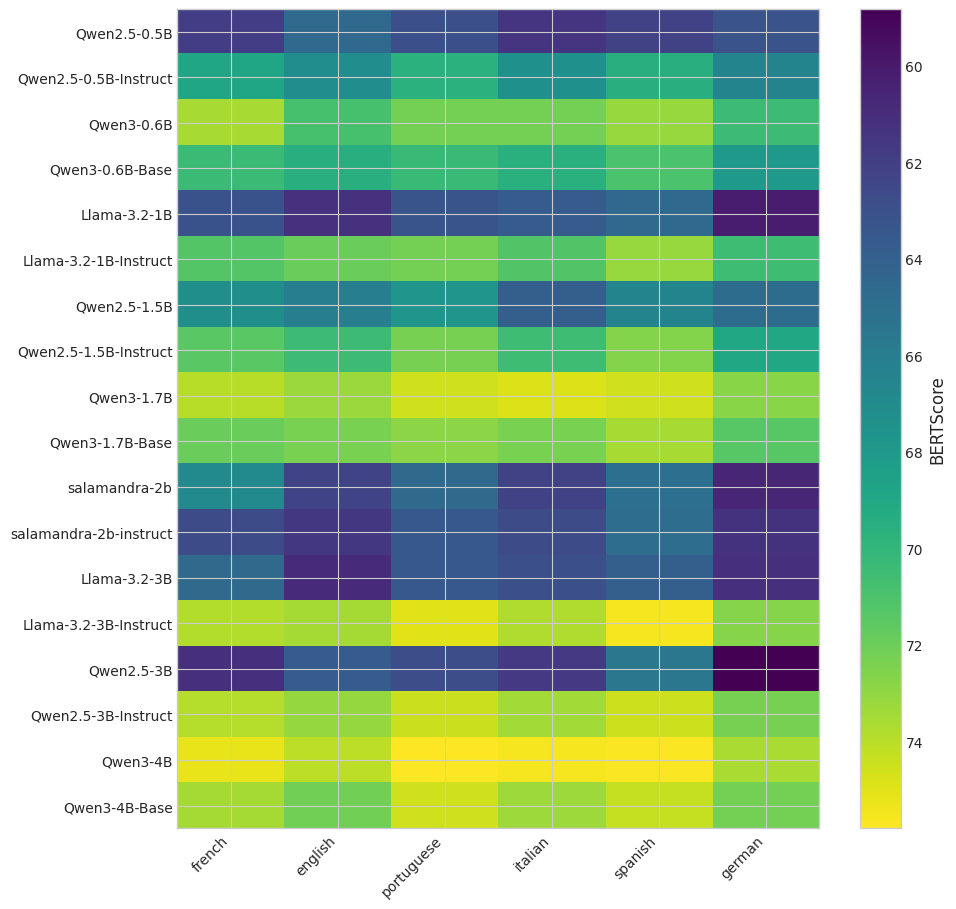

Heatmap of bertscore_f1 scores (ft)

Mejor modelo por idioma:
                best_model  bertscore_f1
language                               
english        Qwen2.5-3B         77.26
french      Qwen3-4B-Base         79.22
italian      Qwen2.5-1.5B         77.42
german      Qwen3-4B-Base         76.99
spanish        Qwen2.5-3B         78.92
portuguese  Qwen3-4B-Base         78.71


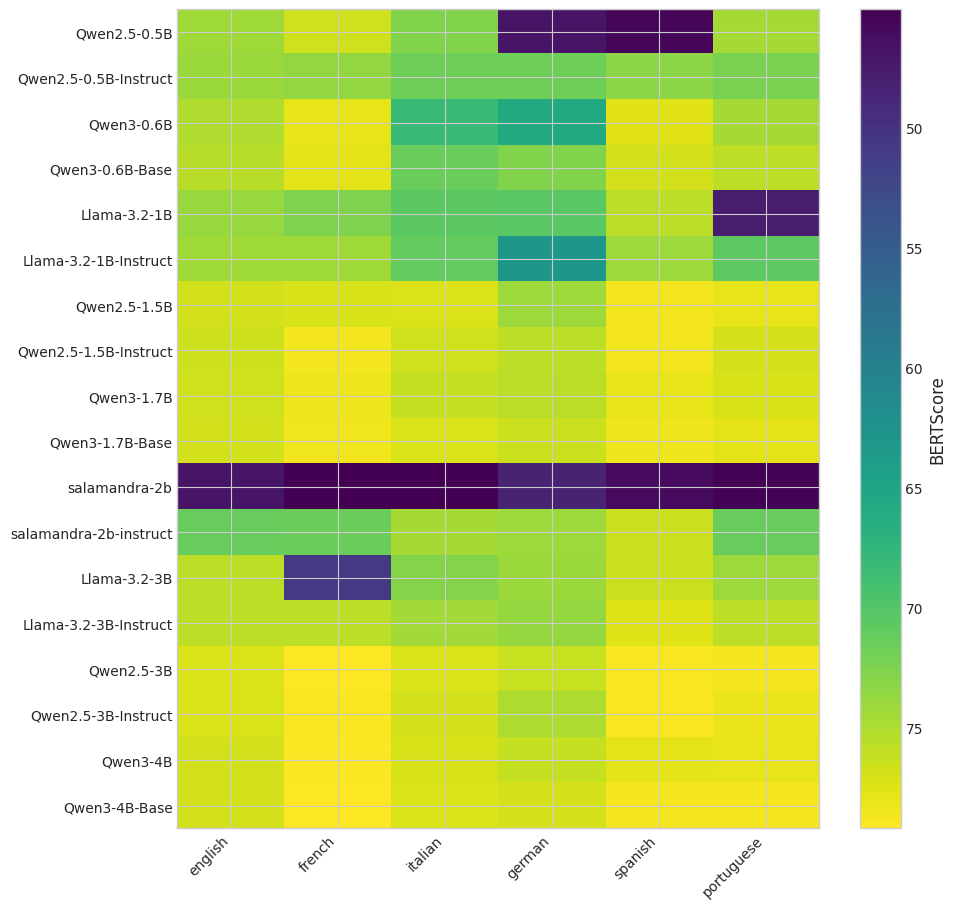

Heatmap of rougeL scores (not_ft)

Mejor modelo por idioma:
                      best_model  rougeL
language                               
french      Qwen2.5-3B-Instruct   22.00
english              Qwen3-1.7B   21.34
portuguese           Qwen3-1.7B   22.72
italian     Qwen2.5-3B-Instruct   18.70
spanish     Qwen2.5-3B-Instruct   23.73
german      Qwen2.5-3B-Instruct   19.20


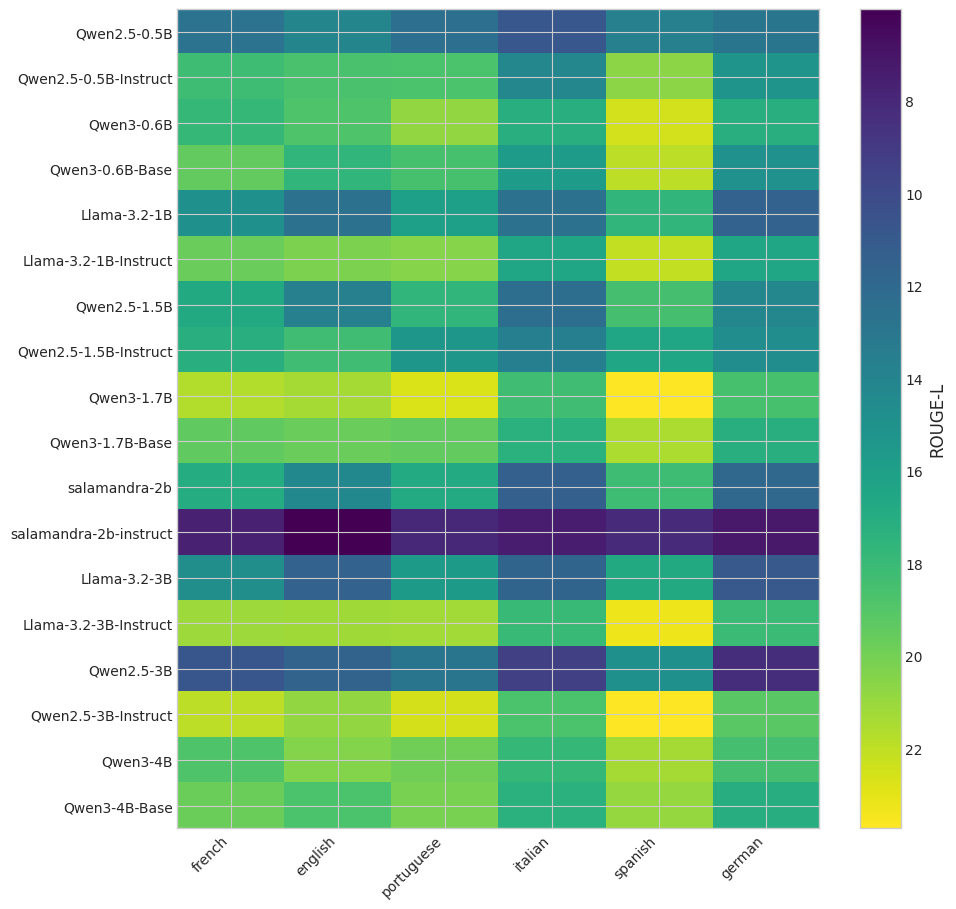

Heatmap of rougeL scores (ft)

Mejor modelo por idioma:
                      best_model  rougeL
language                               
english     Qwen2.5-3B-Instruct   27.33
french      Qwen2.5-3B-Instruct   25.11
italian           Qwen3-4B-Base   22.31
german            Qwen3-4B-Base   22.79
spanish     Qwen2.5-3B-Instruct   28.83
portuguese  Qwen2.5-3B-Instruct   27.38


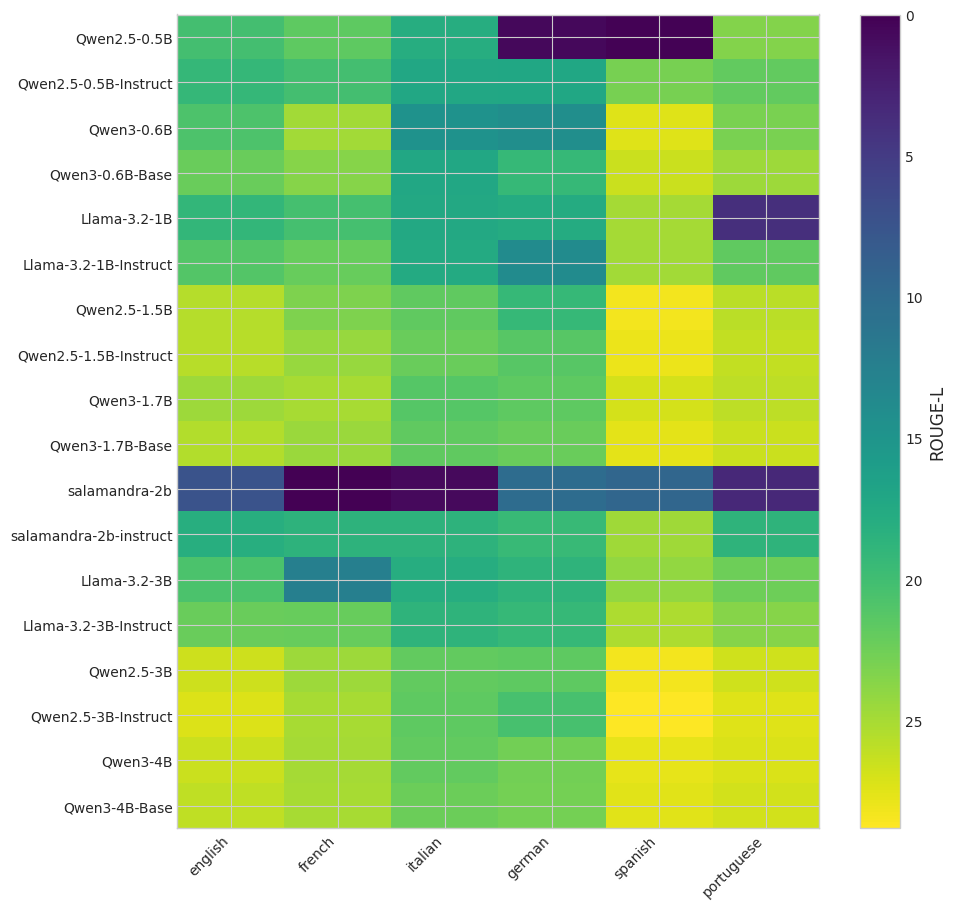

In [177]:

metrics = ["average", "bertscore_f1", "rougeL"]
data_sets = ["not_ft", "ft"]
excluir = ["Llama-3.1-8B-Instruct", "Qwen2.5-7B-Instruct-bnb-4bit"]


for metric in metrics:
    for data_set in data_sets:
        excel_path = f"data/metrics_summary_{data_set}.xlsx"
        title = f"Heatmap of {metric} scores ({data_set})"
        print(title)
        show_metrics_heatmap(
            excel_path,
            metric=metric,
            show_top=True,
            sort_by_size=True,
            exclude_models=excluir,
        )